# Flights Data Exploration
## by Benjamin UWIMANA MAHUKU

## Preliminary Wrangling

> This dataset reports flights in the United States, including
carriers, arrival and departure delays, and reasons for delays,
from 1987 to 2008.The [data](http://stat-computing.org/dataexpo/2009/the-data.html) comes originally from RITA as the website says.  
>Data is not in a single file. There are multiple zipped files, one for each year. Therefore we'll need to download more than one zip files, unzip and join them to have a single file.  
Furthermore, there might be features that will be left aside given that there are not of interrest for this exploration work, but also because of convinience since the size of files is quite big.

In [1]:
# Import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')
sb.set()

> Some preliminary work needs to be done before even loading the dataset. As there are 22 different datasets (one for each year between 1987 and 2008 inclusive) totaling more than 11 GB, it looks to me wiser to select some of them, the second (given that the first year, namely 1987, hasn't data for all months), the middle and the last datasets. This will allow me to compare years’ data looking at what delays have been throughout. However, depending on computer's resources (mainly the RAM), one may prefer to select more datasets to use for this data exploratory project.  
It is worth to notice that these preliminary steps are time consuming, reason why they are commented out to avoid executing them each time we run this notebook.

In [2]:
### Reading selected datasets
# flights_1988 = pd.read_csv("data/1988.csv")
# flights_1998 = pd.read_csv("data/1998.csv")
# flights_2008 = pd.read_csv("data/2008.csv")

In [3]:
### Combining selected datasets in one dataset and saving it to a 'csv' file for future use
# data_frames = [flights_1988, flights_1998, flights_2008]
# flights = pd.concat(data_frames)
# flights.to_csv('flights.csv', index = False)

In [4]:
### Loading the combined dataset
flights = pd.read_csv("data/flights.csv")

> At this point, the following cleaning actions are needed:
1. Select columns of interest. Not all features in the dataset are necessarily connected with delays
2. Merge Datasets:
    * Merge this dataset with *carriers* dataset to get meaningful Carriers
    * Merge this dataset with *airport* dataset to get names of origin and destination airports and cities
3. Rename new columns and drop unnecessary ones
4. Create columns for week day names and month names

In [5]:
### Selecting columns of interest
flights = flights[['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier', 'DepDelay', 'Origin', 
                   'CarrierDelay', 'WeatherDelay', 'NASDelay','SecurityDelay','LateAircraftDelay']]

In [6]:
### Making a copy of the dataset for cleaning purposes
flights_clean = flights.copy()

In [7]:
### Reading 'carriers' dataset and merging it with 'flights' dataset
carriers = pd.read_csv('data/carriers.csv')
flights_clean = pd.merge(flights_clean, carriers, left_on='UniqueCarrier',right_on='Code', how='left')
flights_clean.rename(columns ={'Description': 'Carrier'}, inplace =True)
flights_clean.drop(['UniqueCarrier', 'Code'], axis=1, inplace=True)

In [8]:
### Reading 'airport' dataset and merging it with 'flights' dataset based on origin of flights
airports = pd.read_csv('data/airports.csv')
flights_clean = pd.merge(flights_clean, airports, left_on='Origin',right_on='iata', how='left')
flights_clean.rename(columns ={'airport': 'OriginAirport', 'city': 'OriginCity'}, inplace =True)
flights_clean.drop(['Origin', 'state', 'country', 'lat', 'long', 'iata'], axis=1, inplace=True)

In [9]:
### Making 'DayName' in accordance with given variable descriptions
DayNames = pd.DataFrame({'DayNumber': [1, 2, 3, 4, 5, 6, 7], 
                         'DayName': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']})
flights_clean = pd.merge(flights_clean, DayNames, left_on='DayOfWeek',right_on='DayNumber', how='left')
flights_clean.drop(['DayNumber'], axis=1, inplace=True)

In [10]:
### Making 'MonthName' in accordance with given variable descriptions
MonthNames = pd.DataFrame({'MonthNumber': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 
                         'MonthName': ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                                       'September', 'October', 'November', 'December']})
flights_clean = pd.merge(flights_clean, MonthNames, left_on='Month',right_on='MonthNumber', how='left')
flights_clean.drop(['MonthNumber'], axis=1, inplace=True)

In [11]:
print(flights_clean.shape)
print(flights_clean.dtypes)
print(flights_clean.sample(5))

(17596545, 15)
Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepDelay             float64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
Carrier               object
OriginAirport         object
OriginCity            object
DayName               object
MonthName             object
dtype: object
          Year  Month  DayofMonth  DayOfWeek  DepDelay  CarrierDelay  \
6751933   1998      4          28          2      -2.0           NaN   
4372827   1988     11          12          6      -2.0           NaN   
8127428   1998      7          24          5      17.0           NaN   
3988550   1988     10          20          4       5.0           NaN   
11208353  2008      2           7          4      38.0          31.0   

          WeatherDelay  NASDelay  SecurityDelay  LateAircraftDelay  \
6751933            NaN       NaN 

### What is the structure of your dataset?

> There are 17,596,545 flights in the clean dataset with 15 features (Year, Month, DayofMonth, DayOfWeek, DepDelay, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay, Carrier, OriginAirport, OriginCity, DayName and MonthName). Some variables are numeric in nature (like those whose values are number of minutes), others are just string (like names of airports or carriers), yet others like DayName and MonthName are ordered factor variables with the following levels:  
**DayName**: Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday  
**MonthName**: January, February, March, April, May, June, July, August, September, October, November, December 

### What is/are the main feature(s) of interest in your dataset?

> I'm most interested in figuring out what features are strongly connected with *departure delays* in the dataset.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> There are reasons for departure delays given in the dataset (CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay). But I think that it is important to figure out if departure delays occur on particular day(s) of week, or in a particular month, or at specific airport, or with particular carrier.

## Univariate Exploration

> In this section, I'll investigate distributions of following individual variables: *Year and Month, DayOfWeek, DepDelay, CarrierDelay, WeatherDelay, NASDelay, SecurityDelay, LateAircraftDelay, Carrier, OriginAirport, DayName and MonthName*.

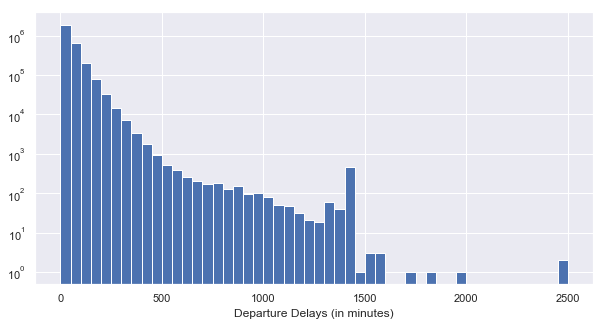

In [12]:
# Plotting the variable of interest, 'DepDelay'
plt.figure(figsize=[10, 5])
bin_edges = np.arange(0, flights_clean['DepDelay'].max()+50, 50)
plt.hist(data = flights_clean[flights_clean['DepDelay'] >= 15], x = 'DepDelay', bins = bin_edges)
plt.yscale('log')
plt.xlabel('Departure Delays (in minutes)')
plt.show()

The above plots shows that there are unusually long period of departure delays that go beyond 1500 minutes, that is more than 24 hours of delay. I consider these flights as outliers or just canceled flights. Thus, lets get rid of them. In addition departure delays that are smaller than 15 minutes will not be consedered as delays and we'll get rid of those also.

In [13]:
### Removing unusual values of departure delays
flights_clean = flights_clean[flights_clean['DepDelay'] >= 15]
flights_clean = flights_clean[flights_clean['DepDelay'] <= 1500]

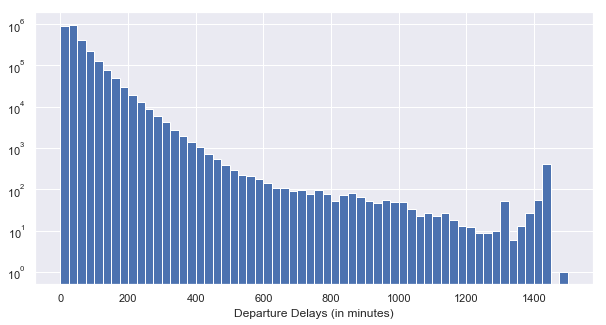

In [14]:
# Plotting the variable of interest, 'DepDelay' again
plt.figure(figsize=[10, 5])
bin_edges = np.arange(0, flights_clean['DepDelay'].max()+25, 25)
plt.hist(data = flights_clean, x = 'DepDelay', bins = bin_edges)
plt.yscale('log')
plt.xlabel('Departure Delays (in minutes)')
plt.show()


The plots shows that most of departure delays are less that 4 hours (240 minutes). It looks like there are some exteme values and we'll need to dig deeper into this.

In [15]:
## Converting DayName, and MonthName into ordered categorical types
ordinal_var_dict = {'DayName': ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                    'MonthName': ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 
                                       'September', 'October', 'November', 'December']}

for var in ordinal_var_dict:
    ordered_var = pd.api.types.CategoricalDtype(ordered = True,
                                                categories = ordinal_var_dict[var])
    flights_clean[var] = flights_clean[var].astype(ordered_var)

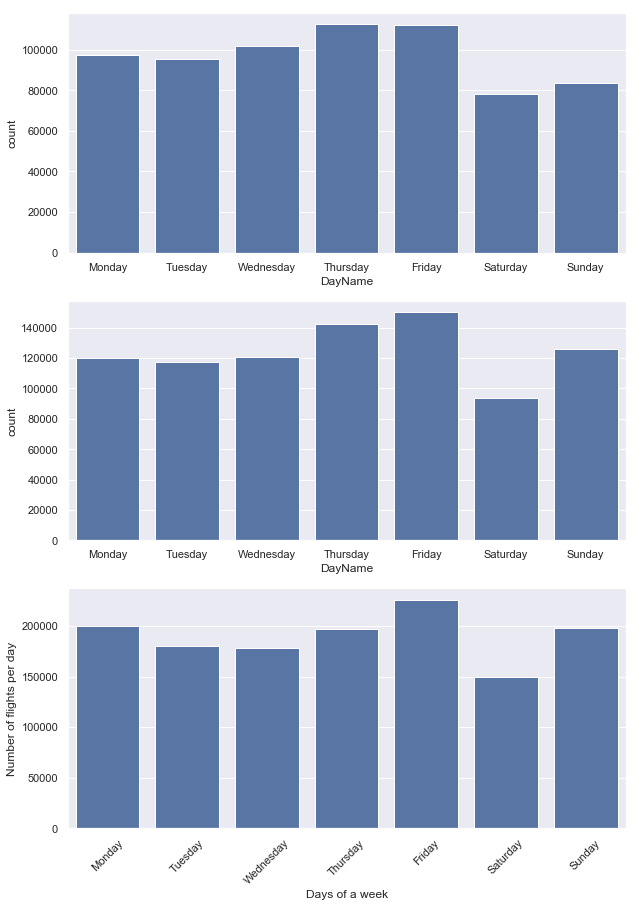

In [16]:
# Plotting departure delays distributions per DAY OF WEEK for years 1988, 1998 and 2008

fig, ax = plt.subplots(nrows=3, figsize=[10, 15])
default_color = sb.color_palette()[0]
sb.countplot(data = flights_clean[flights_clean['Year'] == 1988], x = 'DayName', color = default_color, ax = ax[0])
sb.countplot(data = flights_clean[flights_clean['Year'] == 1998], x = 'DayName', color = default_color, ax = ax[1])
sb.countplot(data = flights_clean[flights_clean['Year'] == 2008], x = 'DayName', color = default_color, ax = ax[2])
plt.xticks(rotation= 45)
plt.ylabel('Number of flights per day')
plt.xlabel('Days of a week');

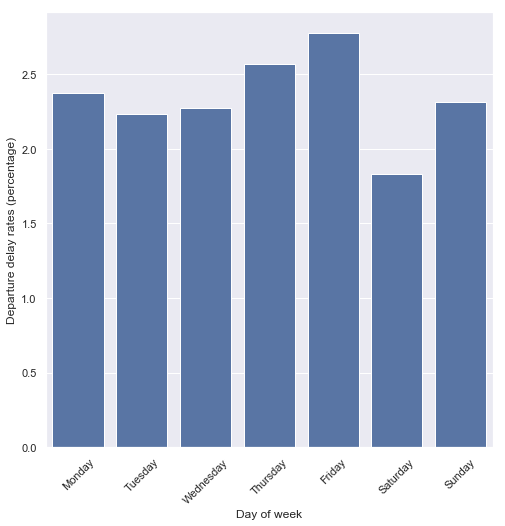

In [17]:
### Plotting 'DayName' having largest depature delay rates
day_delay_rates = (flights_clean['DayName'].value_counts()/flights['DayOfWeek'].shape[0]).sort_values(ascending=False)
day_delay_flight_rates = pd.DataFrame({'Day of week':day_delay_rates.index, 'delay_rate':day_delay_rates.values})
day_delay_flight_rates['delay_rate'] = day_delay_flight_rates['delay_rate'] * 100
plt.figure(figsize=[8, 8])
plt.xticks(rotation= 45)
base_color = sb.color_palette()[0]
sb.barplot(data = day_delay_flight_rates, x = 'Day of week', y= 'delay_rate' , color = base_color)
plt.ylabel('Departure delay rates (percentage)');

>The above plots suggest that Fridays have consistenty recorded more departure delays than other days of a week for the three selected years/datasets (1988, 1998 and 2008). Plotting departure delay rates per day yields further light on this showing that more than 2.5% of fights are delays for departure on Fridays. Saturdays are having smallest departure delay rate (almost 1.8%) for the three selected years.

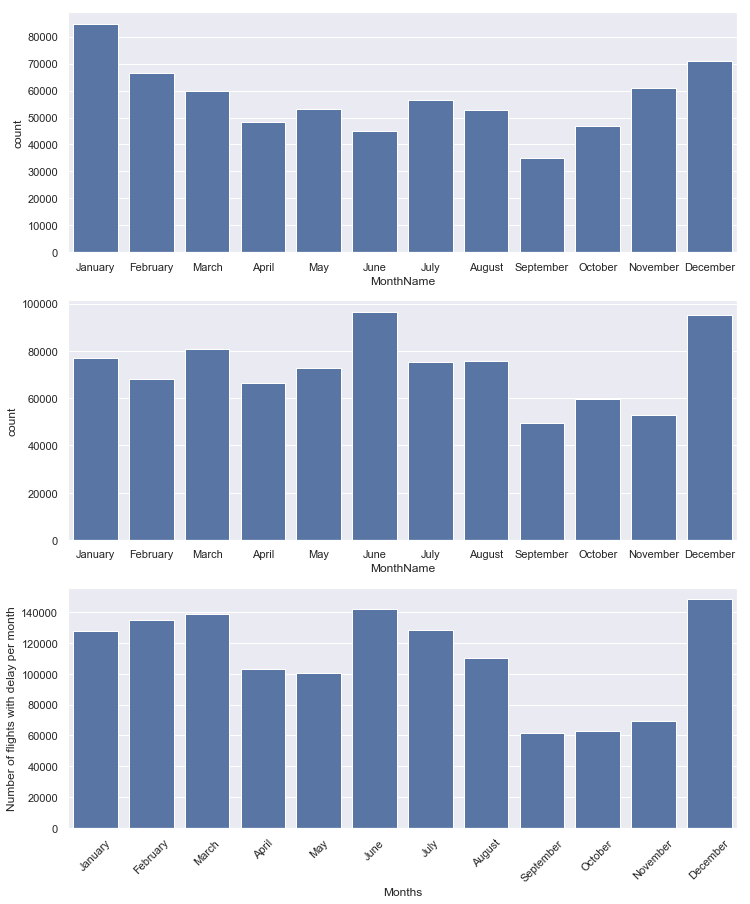

In [18]:
# Plotting departure delays distributions per MONTH for years 1988, 1998 and 2008
fig, ax = plt.subplots(nrows=3, figsize=[12, 15])
default_color = sb.color_palette()[0]
sb.countplot(data = flights_clean[flights_clean['Year'] == 1988], x = 'MonthName', color = default_color, ax = ax[0])
sb.countplot(data = flights_clean[flights_clean['Year'] == 1998], x = 'MonthName', color = default_color, ax = ax[1])
sb.countplot(data = flights_clean[flights_clean['Year'] == 2008], x = 'MonthName', color = default_color, ax = ax[2])
plt.xticks(rotation= 45)
plt.ylabel('Number of flights with delay per month');
plt.xlabel('Months');

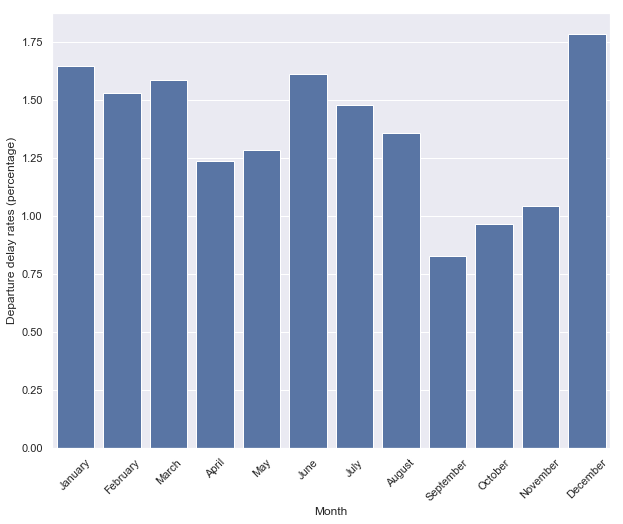

In [19]:
### Plotting 'MonthName' having largest depature delay rates
month_delay_rates = (flights_clean['MonthName'].value_counts()/flights['Month'].shape[0]).sort_values(ascending=False)
month_delay_flight_rates = pd.DataFrame({'Month':month_delay_rates.index, 'delay_rate':month_delay_rates.values})
month_delay_flight_rates['delay_rate'] = month_delay_flight_rates['delay_rate'] * 100
plt.figure(figsize=[10, 8])
plt.xticks(rotation= 45)
base_color = sb.color_palette()[0]
sb.barplot(data = month_delay_flight_rates, x = 'Month', y= 'delay_rate' , color = base_color)
plt.ylabel('Departure delay rates (percentage)');

>The two last selected years (1998 and 2008) have similar distributions. But for the three years taken together, December shows greater departure delays of flights with more that 1.75% of flights delayed for departure. Septermber is having smallest departure delays (almost 0.75% of all departure delayed flights)

In [20]:
# Making ordering of CARRIERS based on count of departure delays
carrier_order_1988 = flights_clean[flights_clean['Year'] == 1988]['Carrier'].value_counts().index
carrier_order_1998 = flights_clean[flights_clean['Year'] == 1998]['Carrier'].value_counts().index
carrier_order_2008 = flights_clean[flights_clean['Year'] == 2008]['Carrier'].value_counts().index

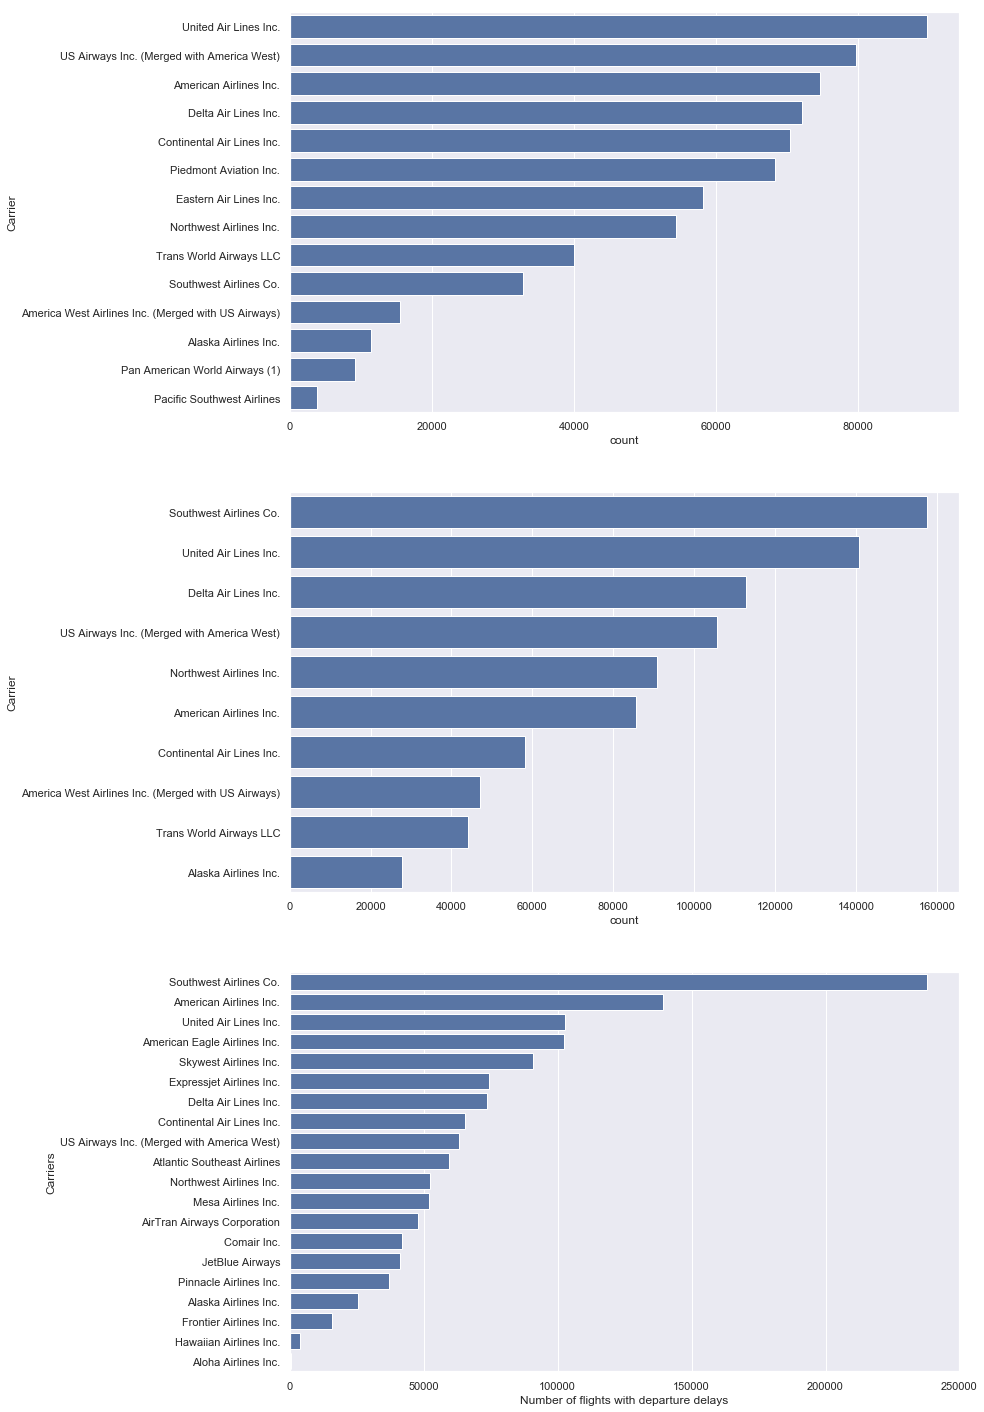

In [21]:
# Plotting departure delays distributions per CARRIER for years 1988, 1998 and 2008
fig, ax = plt.subplots(nrows=3, figsize=[12, 25])
default_color = sb.color_palette()[0]

sb.countplot(data = flights_clean[flights_clean['Year'] == 1988],
             y = 'Carrier', color = default_color, ax = ax[0], order = carrier_order_1988)
sb.countplot(data = flights_clean[flights_clean['Year'] == 1998],
             y = 'Carrier', color = default_color, ax = ax[1], order = carrier_order_1998)
sb.countplot(data = flights_clean[flights_clean['Year'] == 2008],
             y = 'Carrier', color = default_color, ax = ax[2], order = carrier_order_2008)
# plt.xticks(rotation= 45)
plt.ylabel('Carriers');
plt.xlabel('Number of flights with departure delays');

>There are carriers which are found in first ten having most departure delays for the three selected years. These include American Airlines Inc., United Airlines Inc. and Southwest Airlines Co. It is possible that these carriers are also having an overall greater number of flights for the same years. By computing departure delays rate for each carrier will help to understand better this trend.

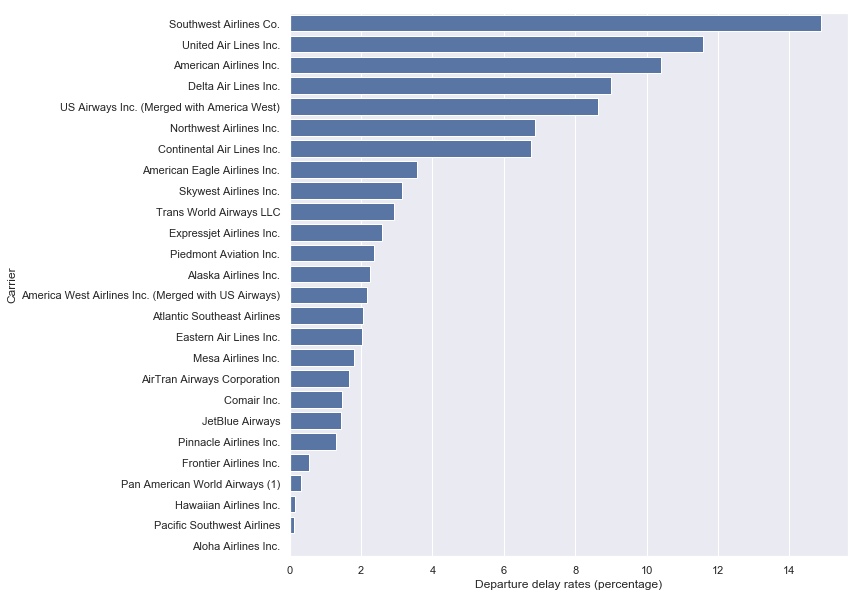

In [22]:
### Plotting depature delay rate per 'Carrier'
carrier_delay_rates = (flights_clean['Carrier'].value_counts()/flights_clean.shape[0]).sort_values(ascending=False)              
carrier_delay_flight_rates = pd.DataFrame({'Carrier':carrier_delay_rates.index, 'Hight_delay_rate':carrier_delay_rates.values})
carrier_delay_flight_rates['Hight_delay_rate'] = carrier_delay_flight_rates['Hight_delay_rate'] * 100
plt.figure(figsize=[10, 10])
base_color = sb.color_palette()[0]
sb.barplot(data = carrier_delay_flight_rates, y = 'Carrier', x= 'Hight_delay_rate' , color = base_color)
plt.xlabel('Departure delay rates (percentage)');

In [23]:
# Making ordering of ORIGIN AIPORTS based on count of departure delays
origin_airport_order_1988 = pd.Series(flights_clean[flights_clean['Year'] == 1988]['OriginAirport'].value_counts())
origin_airport_order_1988 = origin_airport_order_1988.nlargest(20)
origin_airport_order_1988 = pd.DataFrame({'airport':origin_airport_order_1988.index,
                                          'delays':origin_airport_order_1988.values})

origin_airport_order_1998 = pd.Series(flights_clean[flights_clean['Year'] == 1998]['OriginAirport'].value_counts())
origin_airport_order_1998 = origin_airport_order_1998.nlargest(20)
origin_airport_order_1998 = pd.DataFrame({'airport':origin_airport_order_1998.index,
                                          'delays':origin_airport_order_1998.values})

origin_airport_order_2008 = pd.Series(flights_clean[flights_clean['Year'] == 2008]['OriginAirport'].value_counts())
origin_airport_order_2008 = origin_airport_order_2008.nlargest(20)
origin_airport_order_2008 = pd.DataFrame({'airport':origin_airport_order_2008.index,
                                          'delays':origin_airport_order_2008.values})

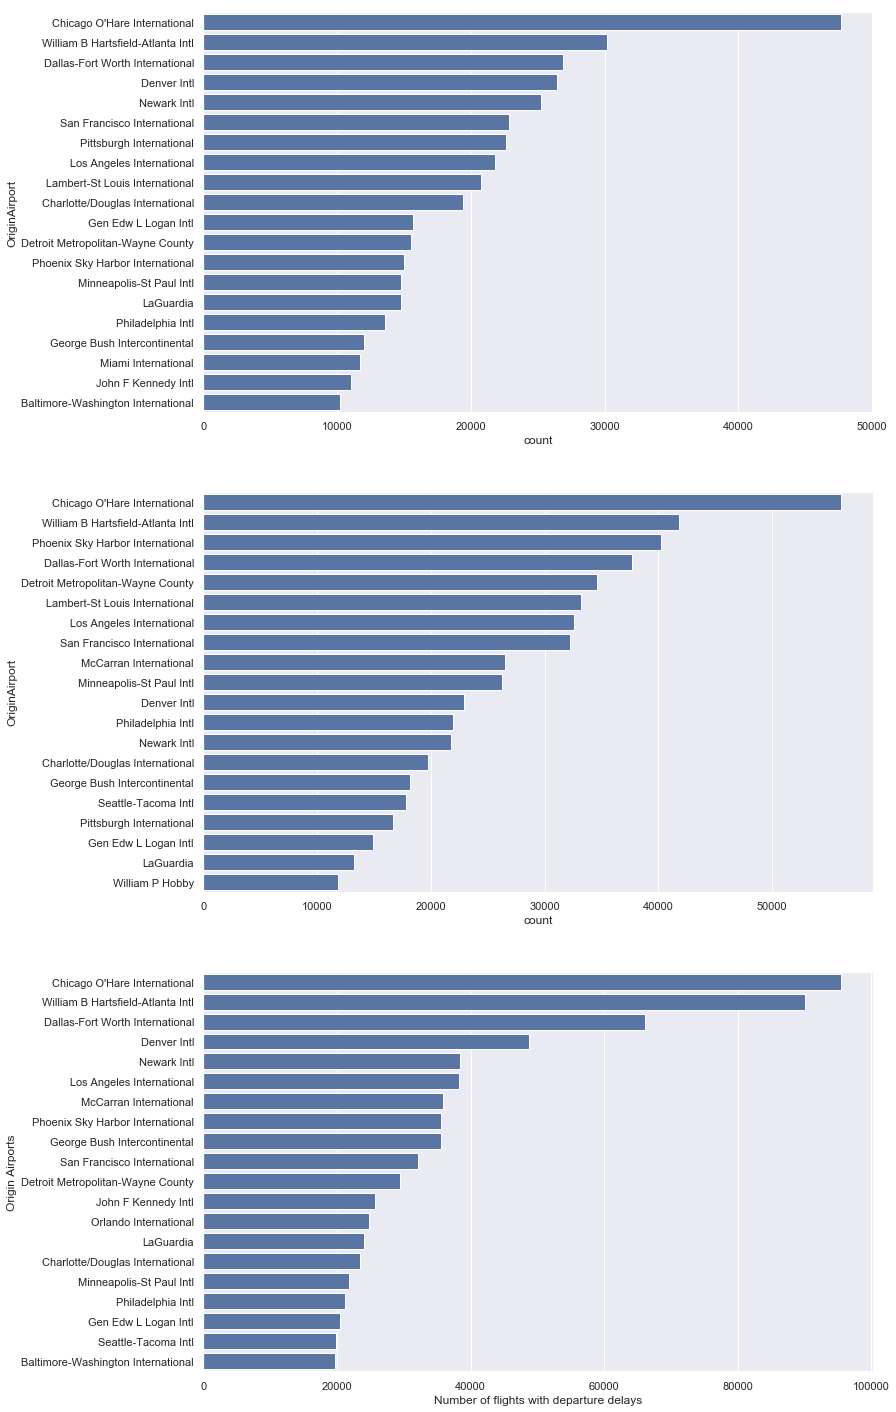

In [24]:
# Plotting 20 largest number departure delays distributions per ORIGIN AIRPORT for years 1988, 1998 and 2008
fig, ax = plt.subplots(nrows=3, figsize=[12, 25])
default_color = sb.color_palette()[0]

sb.countplot(data = flights_clean[flights_clean['Year'] == 1988],
             y = 'OriginAirport', color = default_color, ax = ax[0], order = origin_airport_order_1988['airport'])
sb.countplot(data = flights_clean[flights_clean['Year'] == 1998],
             y = 'OriginAirport', color = default_color, ax = ax[1], order = origin_airport_order_1998['airport'])
sb.countplot(data = flights_clean[flights_clean['Year'] == 2008],
             y = 'OriginAirport', color = default_color, ax = ax[2], order = origin_airport_order_2008['airport'])
plt.ylabel('Origin Airports');
plt.xlabel('Number of flights with departure delays');

> There are airports which are found in first ten having most departure delays for the three selected years. These include Chicago O'Hare International, William B Hartsfield-Atlanta Intl and Dallas-Fort Worth International. It is possible that these airports are also having an overall  greater number of departing flights for the same years. By computing departure delays rate for each airport will yield deeper understanding of the trend.

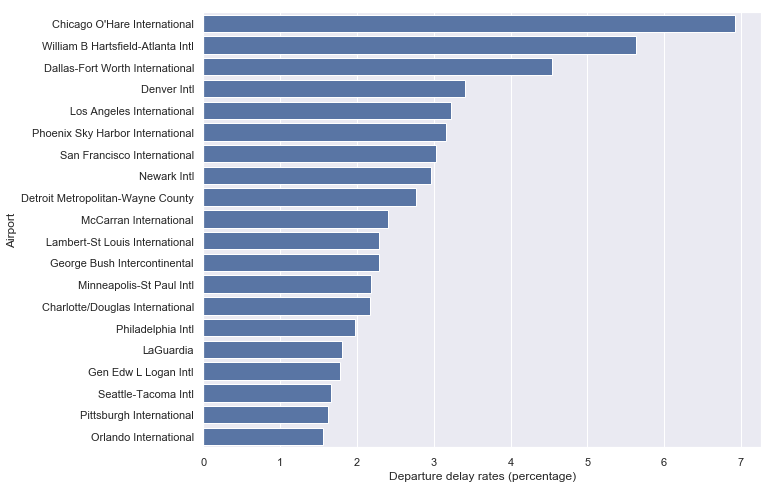

In [25]:
### Plotting 20 'Airport' having largest depature delay rates
airport_delay_rates = (flights_clean['OriginAirport'].value_counts()/flights_clean.shape[0]).sort_values(ascending=False)
airport_delay_flight_rates = pd.DataFrame({'Airport':airport_delay_rates.index, 'delay_rate':airport_delay_rates.values})
airport_delay_flight_rates = airport_delay_flight_rates.head(20)
airport_delay_flight_rates['delay_rate'] = airport_delay_flight_rates['delay_rate'] * 100
plt.figure(figsize=[10, 8])
base_color = sb.color_palette()[0]
sb.barplot(data = airport_delay_flight_rates, y = 'Airport', x= 'delay_rate' , color = base_color)
plt.xlabel('Departure delay rates (percentage)');

It looks like same airports having higher number of fligths with departure delays are also having higher departure delay rates.

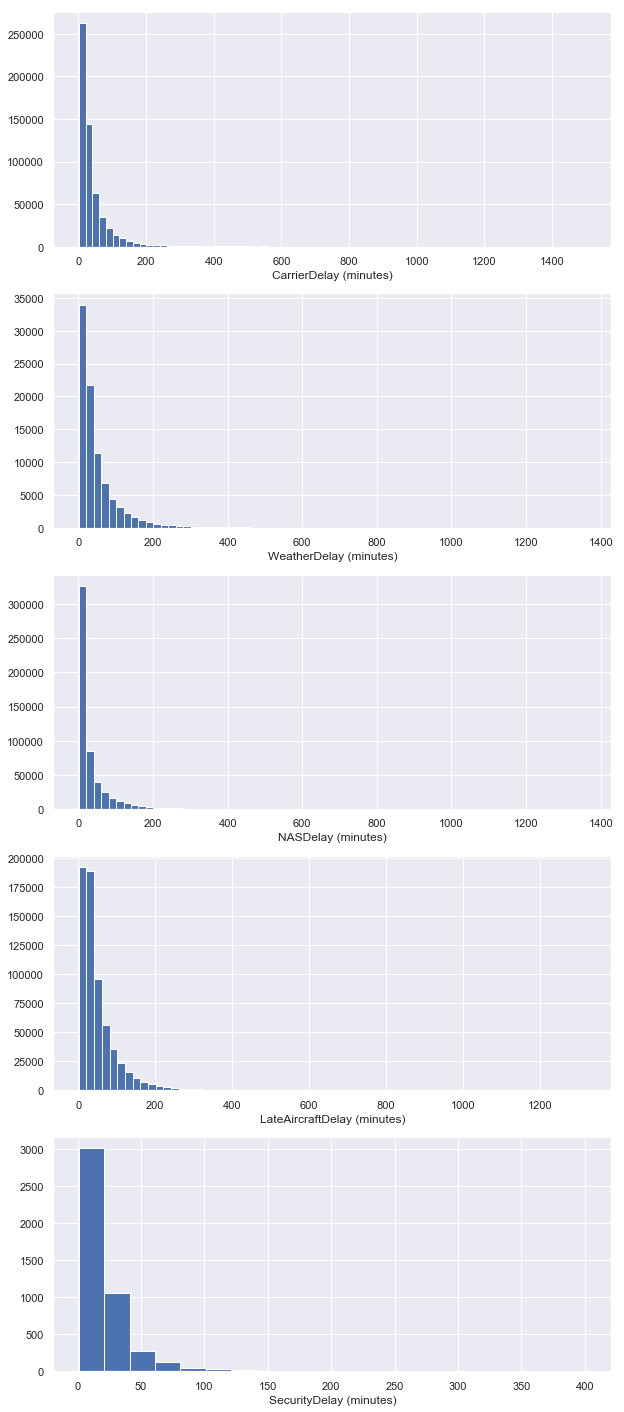

In [26]:
# Plotting the rest of numeric variables
variables = ['DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'SecurityDelay']
flights_delay_causes = flights_clean[variables].query('(CarrierDelay > 0) or (WeatherDelay > 0) or (NASDelay > 0) or \
                                                      (SecurityDelay > 0) or (LateAircraftDelay > 0)')
variables_plots = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'LateAircraftDelay', 'SecurityDelay']
fig, ax = plt.subplots(nrows=5, figsize = [10,25])

for i in range(len(variables_plots)):
    var = variables_plots[i]
    curr_data = flights_delay_causes[flights_delay_causes[var] > 0]
    bins = np.arange(min(curr_data[var]), max(curr_data[var])+20, 20)
    ax[i].hist(data = curr_data, x = var, bins = bins)
    ax[i].set_xlabel('{} (minutes)'.format(var))
plt.show()

On the CarrierDelay, WeatherDelay, NASDelay and LateAircraftDelay plots, we have alsmost similar distribution of data points, suggest these four features are almost equaly impacting flights performance in terms of departure delays. The impact of the SecurityDelay feature is not as important as the others.

In [27]:
### Making departure delays categories
delay_categories = []

### Function to make departure delays categories
def delay_categorie(flights_clean):
    category = ""
    if flights_clean["DepDelay"] <= 30:
        category = "Short"
    elif flights_clean["DepDelay"] <= 60:
        category = "Acceptable"
    elif flights_clean["DepDelay"] <= 120:
        category = "Moderately Long"
    elif flights_clean["DepDelay"] <= 180:
        category = "Long"
    elif flights_clean["DepDelay"] <= 240:
        category = "Very Long"
    else:
        category = "Unusually Very Long"
    delay_categories.append(category)

### Apply the Function to create 'delay_categories' column
flights_clean.apply(delay_categorie, axis=1)

### Assigning categories to 'delay_categories' column
flights_clean['delay_categories'] = delay_categories

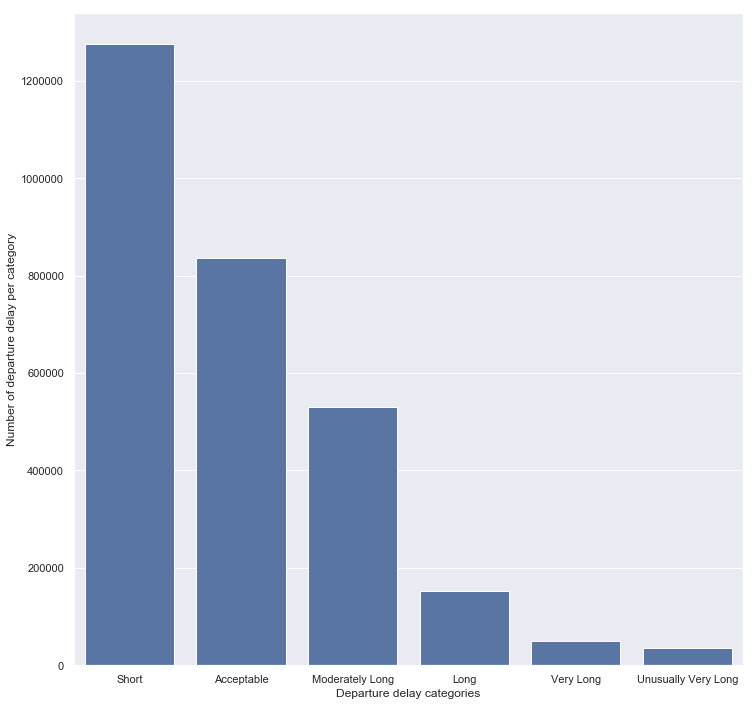

In [28]:
plt.figure(figsize=[12, 12])
catg_order = ["Short", "Acceptable", "Moderately Long", "Long", "Very Long", "Unusually Very Long"]
base_color = sb.color_palette()[0]
sb.countplot(data = flights_clean, x = 'delay_categories' , color = base_color, order = catg_order)
plt.ylabel('Number of departure delay per category')
plt.xlabel('Departure delay categories');

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The *DepDelay* variable had large range of values and big number of data points in bins. For readability sake, I used log scale of the number of data points per bin. It also had unusual departure delays that were more than 24 hours. I considered these instances as outliers or cancels flights and removed them.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Categorical variables including DayOfWeek, Carrier, OriginAirport, DayName and MonthName have big number of flights with departure delays for some specific levels. For better visuals, we computed and plotted departure delay rates for each level where it was needed. Departure delays are very scatted. Therefore for better understanging of how they are spread, we engineered categories of delays feature based on their length as follows:
* less than 30 minutes ==> short
* between 30 and 60 minutes ==> Acceptable
* between 60 and 120 minutes ==> Moderately Long
* between 120 and 180 minutes ==> Long
* between 180 and 240 minutes ==> Very Long
* more than 240 minutes ==> Unusually Very Long

## Bivariate Exploration

> I'll start by investigating correlation relationships present between pairs of variables in the
data.

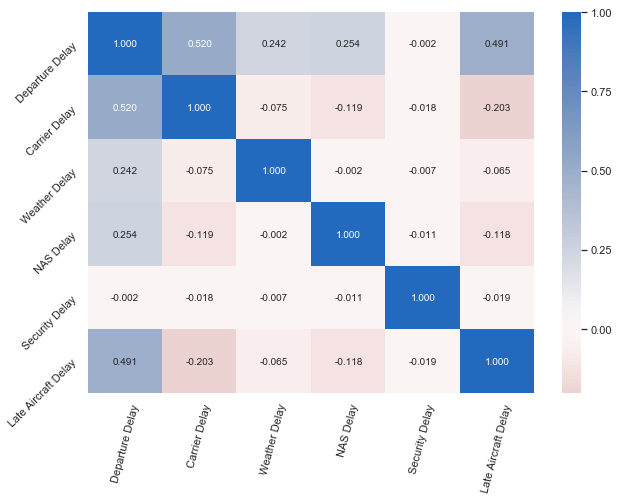

In [29]:
### Making correlation plot
numeric_vars = ['DepDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
plt.figure(figsize = [10, 7])
axis_ticks = ['Departure Delay', 'Carrier Delay', 'Weather Delay', 'NAS Delay', 'Security Delay', 'Late Aircraft Delay']
sb.heatmap(flights_clean[numeric_vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0,
          yticklabels = axis_ticks, xticklabels = axis_ticks)
plt.xticks(rotation= 75)
plt.yticks(rotation= 45)
plt.show()

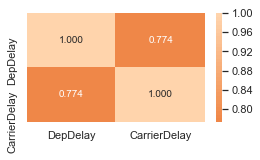

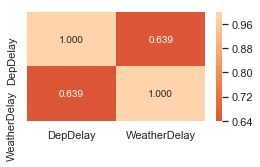

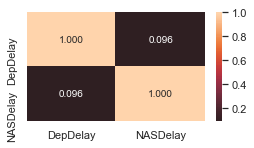

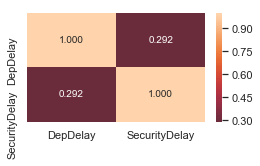

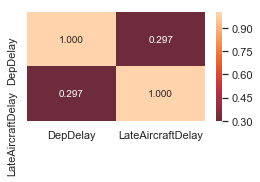

In [30]:
### Checking the correlation of 'DepDelay' with reasons of delay for 'very long' and 'unusually very long' delays
num_vars = ['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
for i in range(len(num_vars)):
    plt.figure(figsize = [4, 2])
    var = num_vars[i]
    flights_clean_causes = flights_clean[(flights_clean[var] > 0) &
                                     ((flights_clean['delay_categories'] == "Unusually Very Long") |
                                     (flights_clean['delay_categories'] == "Very Long"))]
    sb.heatmap(flights_clean_causes[['DepDelay', var]].corr(), annot = True, fmt = '.3f', cmap = 'icefire',
           center = 0) #, yticklabels = axis_ticks, xticklabels = axis_ticks
    plt.show()

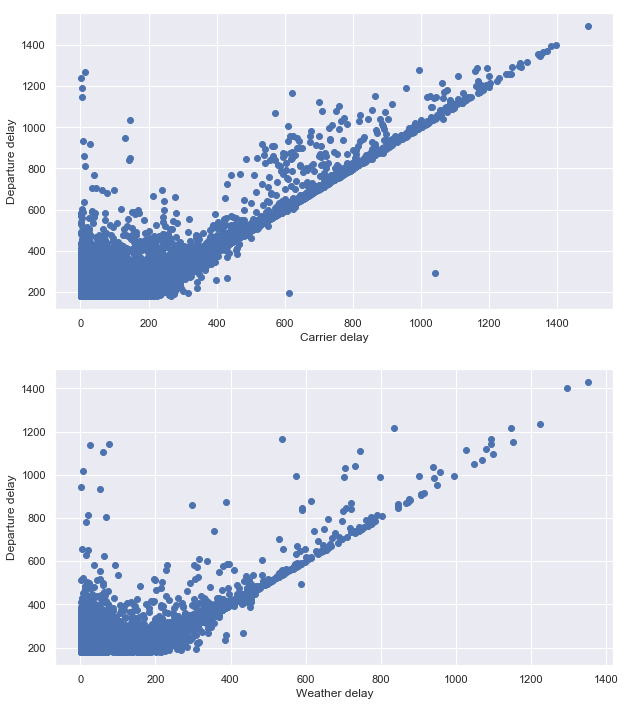

In [31]:
### Plotting 'DepDelay' and its higher correlated reasons of delays
plt.figure(figsize = [10, 12])

# subplot 1: DepDelay vs CarrierDelay
plt.subplot(2, 1, 1)
axis_ticks = ['Dep Delay', 'Carrier Delay']
flights_clean_causes = flights_clean[(flights_clean['CarrierDelay'] > 0) &
                                     ((flights_clean['delay_categories'] == "Unusually Very Long") |
                                     (flights_clean['delay_categories'] == "Very Long"))]
plt.scatter(data = flights_clean_causes, x = 'CarrierDelay', y = 'DepDelay')
plt.xlabel('Carrier delay')
plt.ylabel('Departure delay')

# subplot 2: DepDelay vs WeatherDelay
plt.subplot(2, 1, 2)
flights_clean_causes = flights_clean[(flights_clean['WeatherDelay'] > 0) &
                                     ((flights_clean['delay_categories'] == "Unusually Very Long") |
                                     (flights_clean['delay_categories'] == "Very Long"))]
plt.scatter(data = flights_clean_causes, x = 'WeatherDelay', y = 'DepDelay') #
plt.xlabel('Weather delay')
plt.ylabel('Departure delay')

plt.show()

When we all delayed flighs, it appears that there moderate interaction between 'departure delay' and 'Carrier delay'. But when we consider only 'Very Long' and 'Unusually very long' departure delays, we observe strong correlation between delayed flights and 'Carrier delay' and 'Weather delay' causes of departure delays.

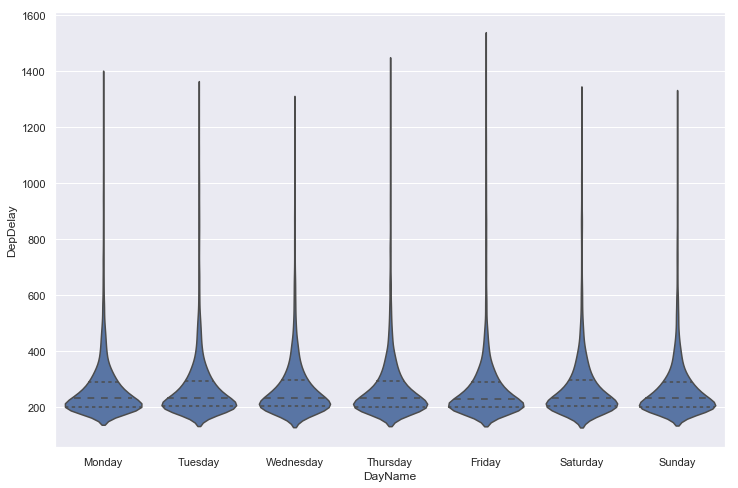

In [32]:
### Plotting sample of delayed flights to look at relation between 'depature delays' and days of week on which they occured
plt.figure(figsize = [12, 8])
#flights_clean_sample = flights_clean.sample(200)
flights_clean_sample = flights_clean[(flights_clean['CarrierDelay'] > 0) &
                                     ((flights_clean['delay_categories'] == "Unusually Very Long") |
                                     (flights_clean['delay_categories'] == "Very Long"))]
sb.violinplot(data = flights_clean_sample, x = 'DayName',
              y = 'DepDelay', color = base_color, inner = 'quartile');

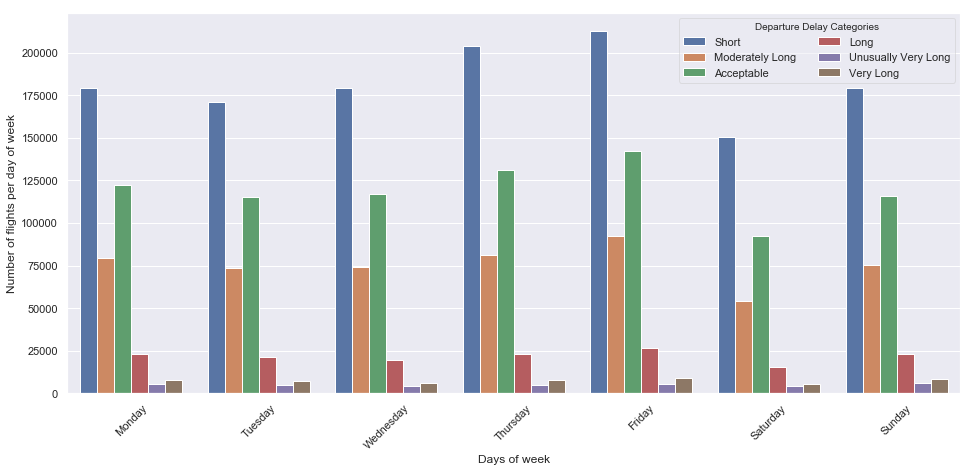

In [33]:
### Plotting relationship between 'delay categories/levels' and days of week on which they occured
plt.figure(figsize=[16, 7])
sb.countplot(data = flights_clean, x = 'DayName', hue = 'delay_categories')
plt.xticks(rotation= 45)
plt.ylabel('Number of flights per day of week');
plt.xlabel('Days of week')
plt.legend(loc = "upper right", title = "Departure Delay Categories", ncol = 2, framealpha = 0.5) ;

The full set of delayed flights shows that Fridays tend to have bigger number of them. But it looks like very long and unsually very long departure delays are likely to happen on any day of the week. This is in accordance with the causes of delays which showed strong correlation between these kind of delays and 'Carrier delay' and 'Weather delay' causes of departure delays

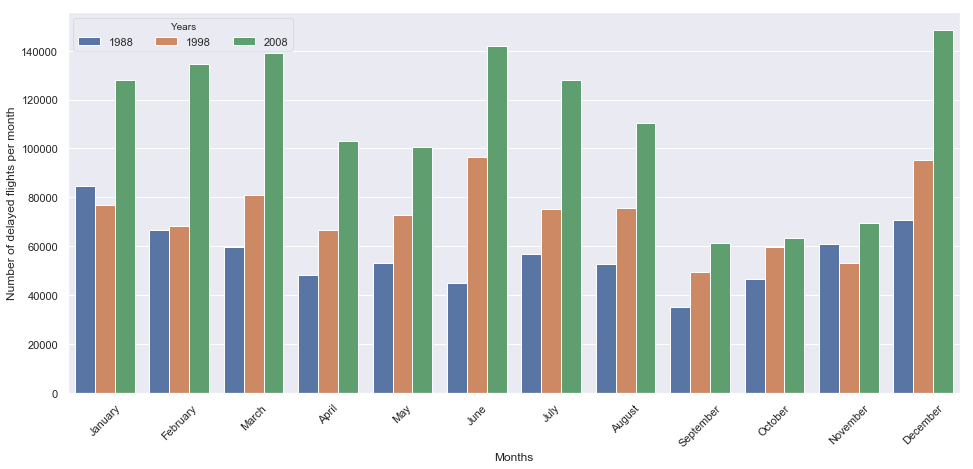

In [34]:
### Checking if more flight delays occured during specific month of year
plt.figure(figsize=[16, 7])
sb.countplot(data = flights_clean, x = 'MonthName', hue = 'Year')
plt.xticks(rotation= 45)
plt.ylabel('Number of delayed flights per month');
plt.xlabel('Months')
plt.legend(loc = "upper left", title = "Years", ncol = 3, framealpha = 0.5);

Of the three selected years, the last two (1998 and 2008) seem to show that we have more departure delays in December and June. This is a confirmation of what we've seen previously, showing that december had highest depature delays among all months throughout the three selected years.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Two reasons of departure delays ('Carrier delay' and 'Weather delay') are in strong correlation with 'Very Long' and 'Unusually very long' departure delays categories. For the last two selected years(1998 and 2008) we have more departure delays in December and June. It could be interresting to know the reasons of these delays. Also we observed that on Fridays we have slightly bigger number of departure delayed flights than other days.  
In next section we'll look at reasons behind these delays for specific month and specfic day of week.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> For the three selected years(1987, 1998 and 2008) we notice that there are months(April, May, September, October and November) that are having considerably fewer flights than others.

## Multivariate Exploration

> In this section we'll concentrate our attention on impact of departure delay reasons on flights performance, origin airports where they occur and how they relate to unique carriers.

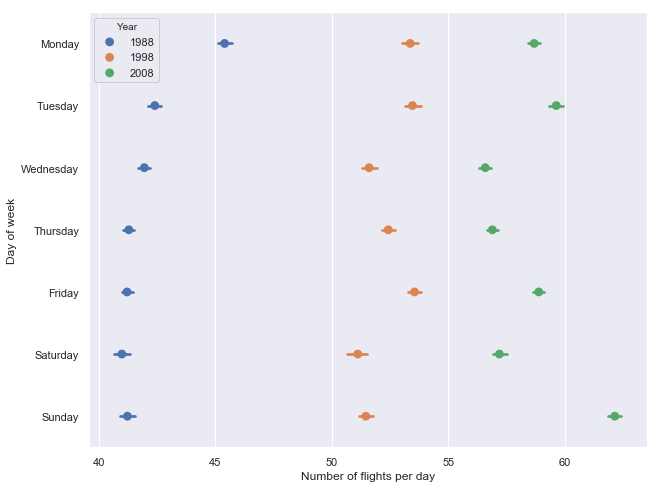

In [35]:
### First, let's check how the number of flight departure delays increased per day and per year
plt.figure(figsize=[10, 8])
ax = sb.pointplot(data = flights_clean, y = 'DayName', x = 'DepDelay', hue = 'Year', linestyles = "")
ax.legend(loc = "upper left", framealpha = 1, title = 'Year')
plt.xlabel('Number of flights per day')
plt.ylabel('Day of week');

> As expected, the number of flights with depature delays increased as years go by, mainly because number of flights itself increased drastically. We expect that we'll have more and more passengers as time passes by because of increased mobility of people

In [36]:
### Retrieving only flights with delay reasons recorded.
flights_delay_reasons = flights_clean[(flights_clean['CarrierDelay'] > 0) | (flights_clean['WeatherDelay'] > 0) |
                                     (flights_clean['NASDelay'] > 0) | (flights_clean['SecurityDelay'] > 0) | 
                                     (flights_clean['LateAircraftDelay'] > 0)]

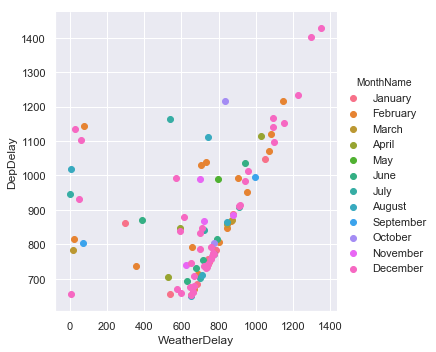

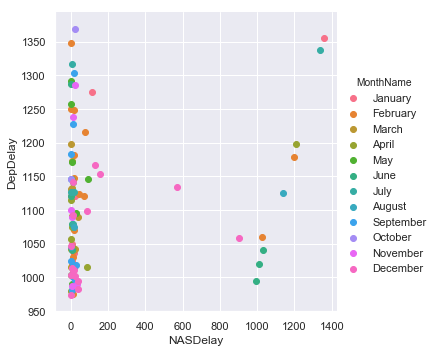

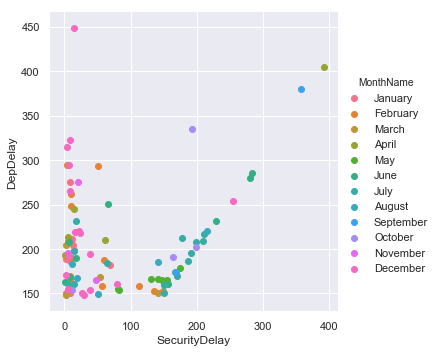

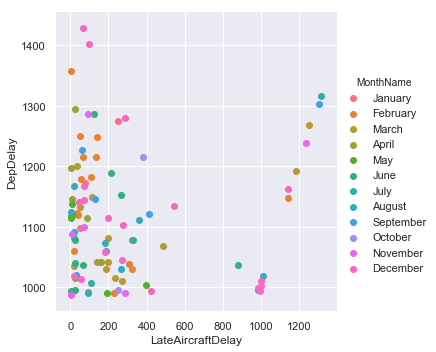

In [37]:
### Checking the impact of different reasons of delay on flights departure performance in each month
reason_vars = ['WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']
for i in range(len(reason_vars)):
    var = reason_vars[i]
    delay_reason = flights_delay_reasons[flights_delay_reasons[var] > 0][['MonthName', 'DepDelay', var]]
    delay_reason.sort_values(['DepDelay', var], ascending = False, inplace = True)
    delay_reason = delay_reason.head(100) #Take only 100 longest departure delays for visibility

    g = sb.FacetGrid(data = delay_reason, hue = 'MonthName', size = 5)
    g.map(plt.scatter, var, 'DepDelay')
    g.add_legend();


In [38]:
### List to hold delay reasons
delay_reasons = []

### Function to extract assign delay reasons
def delay_reason(flights_delay_reasons):
    reason = "None"
    reason_value = 0.0
    if flights_delay_reasons["CarrierDelay"] > 0:
        reason = "Carrier Delay"
        reason_value = flights_delay_reasons["CarrierDelay"]
    if flights_delay_reasons['WeatherDelay'] > reason_value:
        reason = "Weather Delay"
        reason_value = flights_delay_reasons["WeatherDelay"]
    if flights_delay_reasons['NASDelay'] > reason_value:
        reason = "NAS Delay"
        reason_value = flights_delay_reasons["NASDelay"]
    if flights_delay_reasons['SecurityDelay'] > reason_value:
        reason = "Security Delay"
        reason_value = flights_delay_reasons["SecurityDelay"]
    if flights_delay_reasons['LateAircraftDelay'] > reason_value:
        reason = "Late Aircraft Delay"
    delay_reasons.append(reason)

### Apply the Function to create delay reasons column
flights_delay_reasons.apply(delay_reason, axis=1)

### Assigning delay reason to 'reason' column
flights_delay_reasons['Delay Reasons'] = delay_reasons

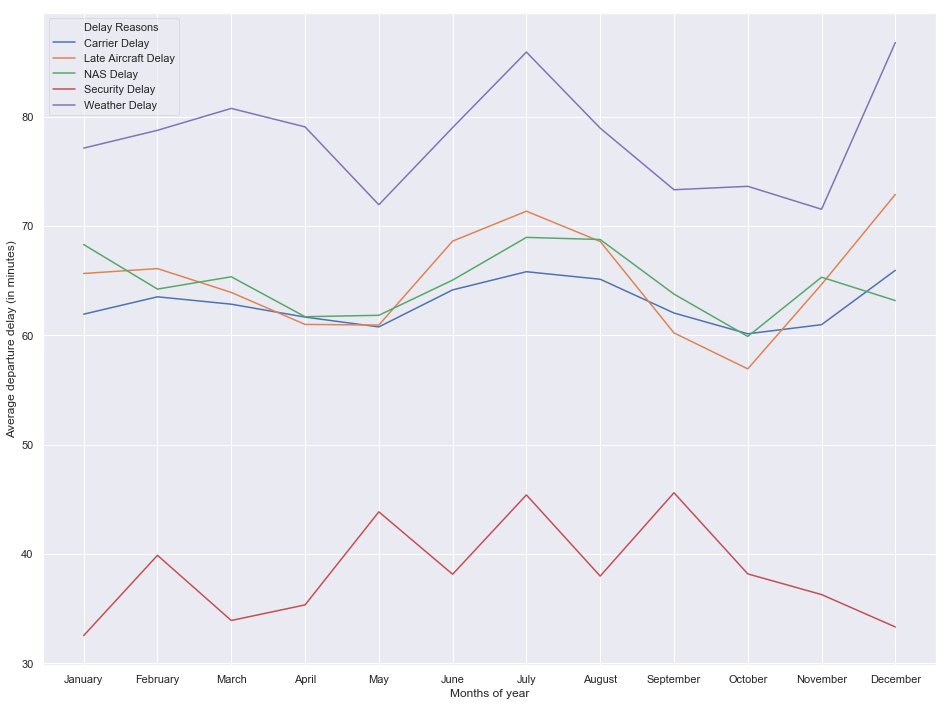

In [43]:
### Use different plot type to check the impact of different reasons of delay on flights departure performance in each month
plt.figure(figsize=[16, 12])
monthly_delay_reason_avg = flights_delay_reasons[['Delay Reasons','MonthName', 'DepDelay']]
monthly_delay_reason_avg = monthly_delay_reason_avg.groupby(
    ['Delay Reasons','MonthName']).agg({'DepDelay': "mean"}).reset_index()
ax = sb.lineplot(data=monthly_delay_reason_avg,x="MonthName", y="DepDelay", hue="Delay Reasons")
plt.xlabel('Months of year')
plt.ylabel('Average departure delay (in minutes)')
plt.legend(loc = "upper left", framealpha = 0.5);

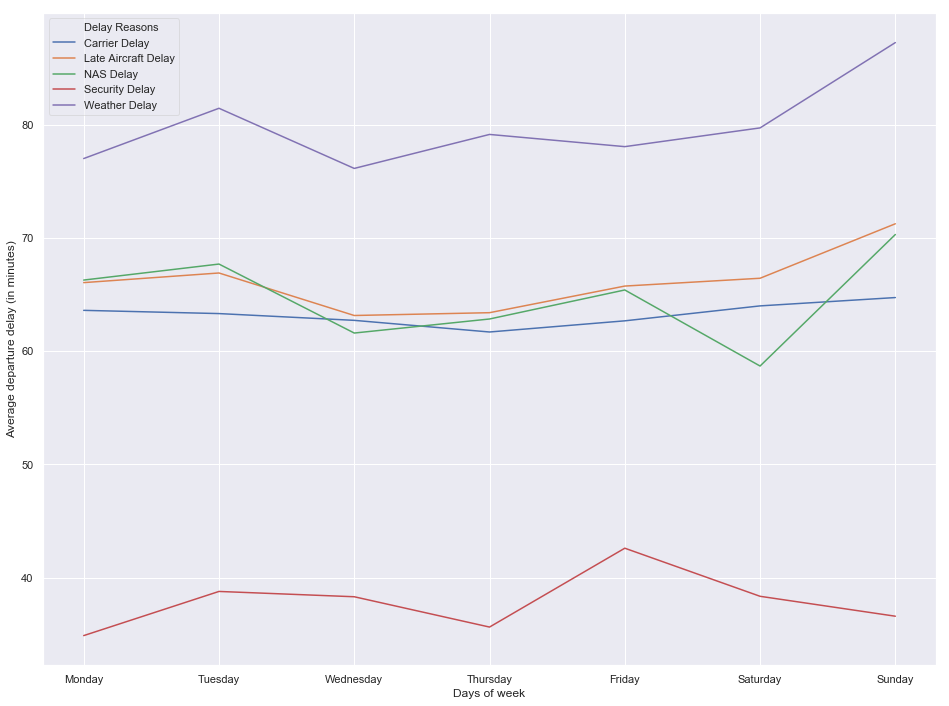

In [44]:
### Checking the impact of different reasons of delay on flights departure performance on each day
plt.figure(figsize=[16, 12])
daily_delay_reason_avg = flights_delay_reasons[['Delay Reasons','DayName', 'DepDelay']]
daily_delay_reason_avg = daily_delay_reason_avg.groupby(
    ['Delay Reasons','DayName']).agg({'DepDelay': "mean"}).reset_index()
ax = sb.lineplot(data=daily_delay_reason_avg,x="DayName", y="DepDelay", hue="Delay Reasons")
plt.xlabel('Days of week')
plt.ylabel('Average departure delay (in minutes)')
plt.legend(loc = "upper left", framealpha = 0.5);

> The above plots show that 'Weather Delay' is causing longest departure delays (around 80 minutes on average per month). On the other hand, among other delay reasons, 'Security Delay' is having shortest departure delays (around 35 minutes on average per month). The same trend is observed when we look at average departure delays per day of week.

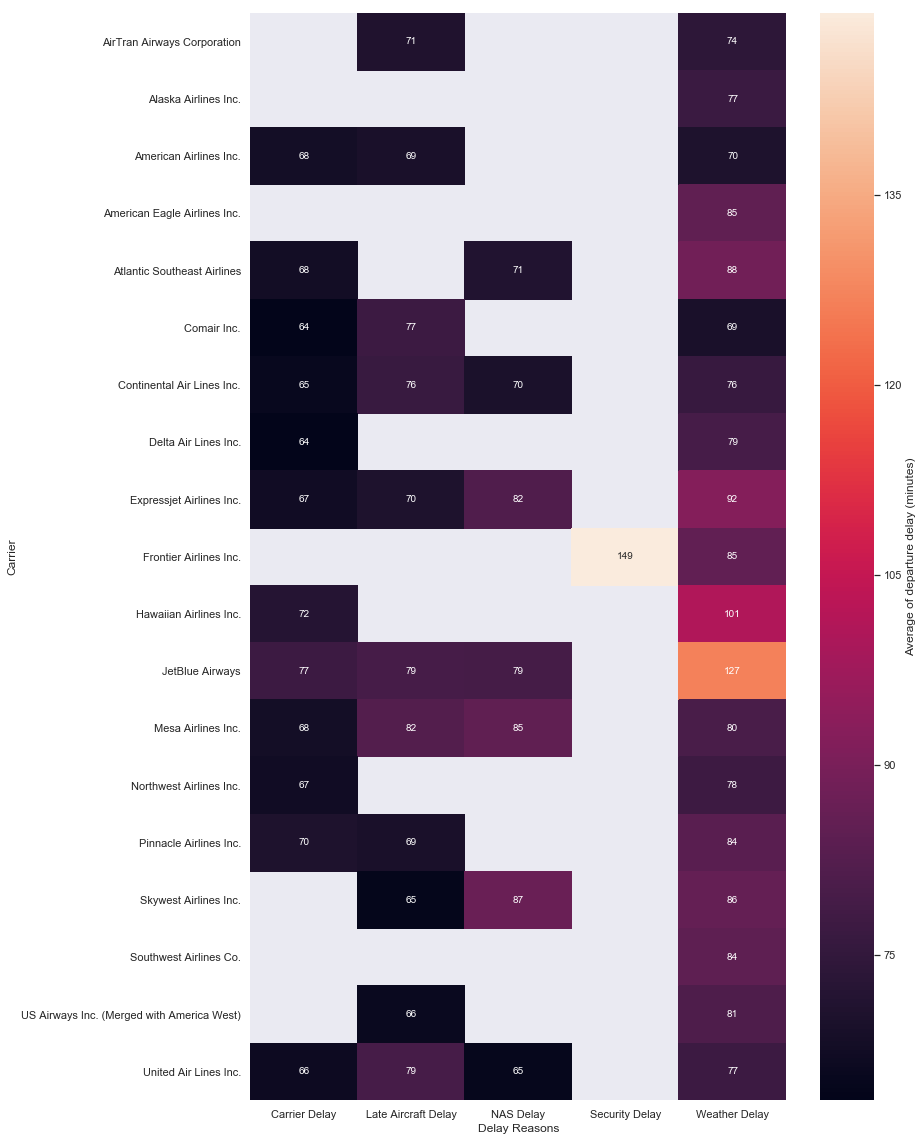

In [41]:
### Checking reasons of delay relate to unique carrier in terms of flights departure delays
plt.figure(figsize=[12, 20])
carrier_delay_reason_avg = flights_delay_reasons[['Delay Reasons','Carrier', 'DepDelay']]
carrier_delay_reason_avg = carrier_delay_reason_avg.groupby(
    ['Delay Reasons','Carrier']).agg({'DepDelay': "mean"}).reset_index()
carrier_delay_reason_avg.sort_values(["DepDelay"],  ascending = False, inplace = True) #
carrier_delay_reason_avg = carrier_delay_reason_avg.head(50)
carrier_delay_reason_avg = carrier_delay_reason_avg.pivot(index = 'Carrier',
                                                                        columns = 'Delay Reasons', values = 'DepDelay')

sb.heatmap(carrier_delay_reason_avg, annot = True, fmt = '.0f',
           cbar_kws = {'label' : 'Average of departure delay (minutes)'});
#plt.yticks(rotation= 45);

> It seems that 'Weather Delay' is the most prominent reason of departure delays impacting most of unique carriers followed by, 'Late Aircraft Delay' and 'Carrier Delay' departure delay reasons. 'Security reason' seems to impact fewer unique carriers.

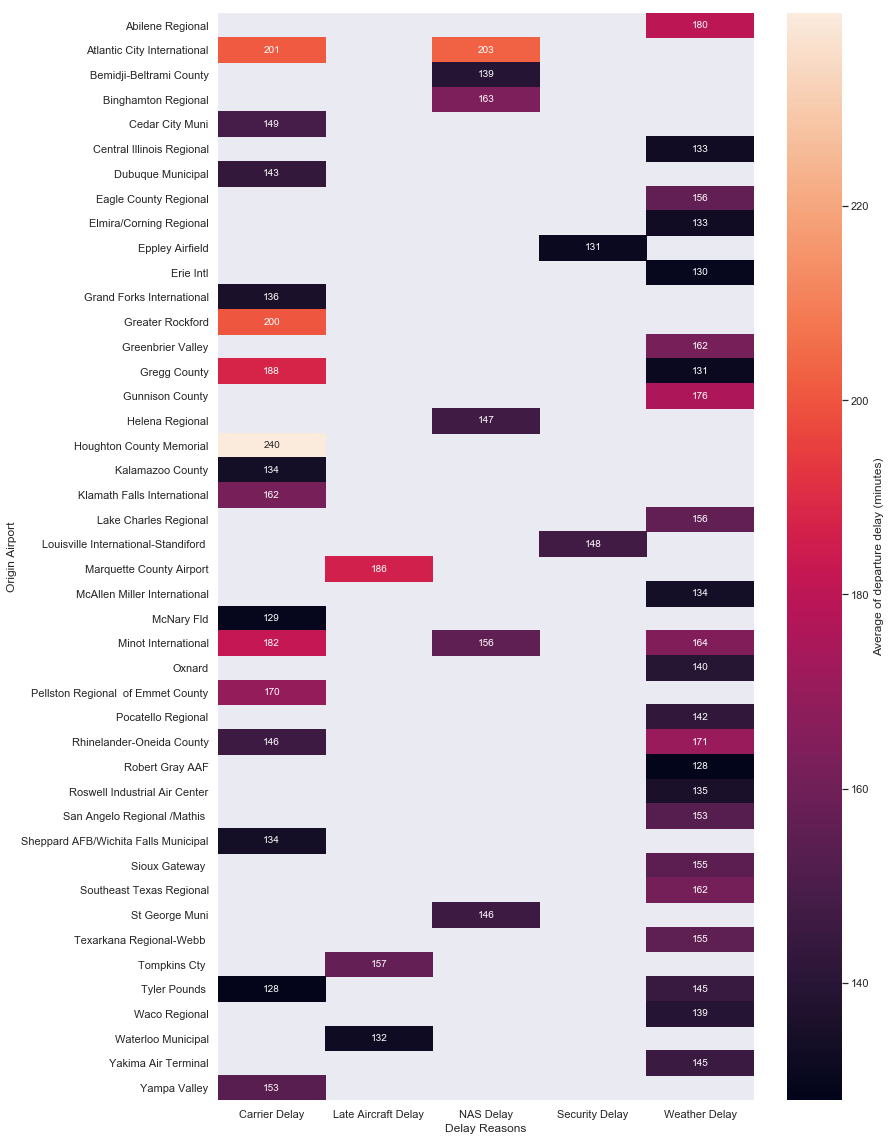

In [42]:
plt.figure(figsize=[12, 20])
origin_airport_delay_reason_avg = flights_delay_reasons[['Delay Reasons','OriginAirport', 'DepDelay']]
origin_airport_delay_reason_avg = origin_airport_delay_reason_avg.groupby(
    ['Delay Reasons','OriginAirport']).agg({'DepDelay': "mean"}).reset_index()
origin_airport_delay_reason_avg.sort_values(["DepDelay"],  ascending = False, inplace = True) #
origin_airport_delay_reason_avg = origin_airport_delay_reason_avg.head(50)
origin_airport_delay_reason_avg = origin_airport_delay_reason_avg.pivot(index = 'OriginAirport',
                                                                        columns = 'Delay Reasons', values = 'DepDelay')

sb.heatmap(origin_airport_delay_reason_avg, annot = True, fmt = '.0f',
           cbar_kws = {'label' : 'Average of departure delay (minutes)'})
plt.ylabel('Origin Airport');

> Same trend of relationship between unique carriers and reasons of departure delays is observed also between origin airports and departure delay reasons. Still weather and carrier delays are affecting most airports than other reasons of departure delays.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> There are relationships between different reasons of departure delays and actual departure delays, also between those reasons and unique carriers and different airports of origin for different fights.  
Of all reasons departure delays, weather and carrier delay reasons are most observed having higher impact on flights performance in terms of departure delays.
In addition, we can see that the impact on weather delay reason is even greater in December that in other months of the year. While one could expect that security reason could cause most of flights departure delays, it is not the case.

### Were there any interesting or surprising interactions between features?

> Because of security checks on different airports, I expected 'Security reason' impacting negatively performance of flights in terms of departure delays. But it looks like this is not the case. Maybe because other security measures put in place like long time to report to airport before departure, which is a burden on shoulders of passengers instead, but good for everyone’s safety.